# 📘 Analyse de sentiment de critiques de films
Ce notebook vous guide dans la construction d’un modèle de Machine Learning pour prédire si une critique de film est **positive** ou **négative**.

## 📥 1. Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Marius
[nltk_data]     Peguy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 📂 2. Chargement du dataset

In [2]:
df = pd.read_csv('movie_reviews_dataset.csv')

print("Exemple de Critiques avec sentiments.")
#Affichage des premieres lignes du jeu de données.
df.head()

Exemple de Critiques avec sentiments.


,review,sentiment
0,Very disappointing. I expected much more.,negative
1,Badly directed and full of clichés.,negative
2,"An outstanding piece of cinema, highly recomme...",positive
3,Poor acting and a completely predictable plot.,negative
4,Very disappointing. I expected much more.,negative


## 🔍 3. Analyse exploratoire rapide

Exemple de Critique Positives :
1. An outstanding piece of cinema, highly recommended.
2. A touching and inspiring story that stays with you.

Exemple de Critique Negatives : 
1. Very disappointing. I expected much more.
2. Badly directed and full of clichés.

Répartition des sentiments:
sentiment
negative    500
positive    500
Name: count, dtype: int64
Nombre moyen de mots (critiques): 7.7


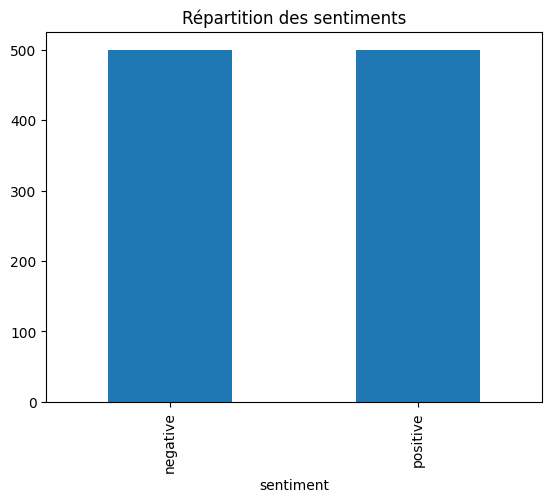

In [3]:
#Exemple de Critiques
print("Exemple de Critique Positives :")
positives = df[df['sentiment']== 'positive']['review'].head(2)
for i, review in enumerate(positives, 1):
        print(f"{i}. {review}")

print("\nExemple de Critique Negatives : ")
negatives = df[df['sentiment']== 'negative']['review'].head(2)
for i, review in enumerate(negatives, 1):
        print(f"{i}. {review}")
#Comptage des classes
print("\nRépartition des sentiments:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

#Calcul et affichage de la longueur moyenne des textes de Critiques.
df['nb_mots'] = df['review'].str.split().str.len()
print(f"Nombre moyen de mots (critiques): {df['nb_mots'].mean():.1f}")


df['sentiment'].value_counts().plot(kind='bar', title='Répartition des sentiments')
plt.show()

## 🧼 4. Prétraitement du texte

In [4]:

def nettoyer_texte(text):
    #Conversion en minuscule
    text = text.lower()

    #Suppression des caracters speciaux et chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Tokenisation NB: j'utilise nltk ici parceque c'est assez simple d'utilisation et bien documente c'est avec cette librairie que j'appris le NLP
    tokens = text.split()

    #Suppression des stops Words anglais puisaque les critiques sont en anglais.
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return ' '.join(tokens)

#Application du nettoyage sur les critiques
df['cleaned_review'] = df['review'].apply(nettoyer_texte)

#longeur moyenne des critiques apres nettoyage
df['nb_mots_nettoyes'] = df['cleaned_review'].str.split().str.len()
print(f"Nombre moyen de mots (nettoyés): {df['nb_mots_nettoyes'].mean():.1f}")

#Affichage des premiers lignes pour les deux jeu de donnees.
#A gauche les critiques originales et a droites, les critiques nettoyes.
df[['review', 'cleaned_review']].head()

Nombre moyen de mots (nettoyés): 4.7


,review,cleaned_review
0,Very disappointing. I expected much more.,disappointing expected much
1,Badly directed and full of clichés.,badly directed full clichs
2,"An outstanding piece of cinema, highly recomme...",outstanding piece cinema highly recommended
3,Poor acting and a completely predictable plot.,poor acting completely predictable plot
4,Very disappointing. I expected much more.,disappointing expected much


## 🧠 5. Vectorisation et séparation des données

In [5]:
##L'objectif ici est principalement de rendre les donnees textuelles comprehensibles par notre futur modele.
X = df['cleaned_review'] #Categorie des revues netoyes biensur
y = df['sentiment']#Categories des sentiment (Ici on aura que deux valeurs : positive et negative)

#Voici les chiffres
print("Donnees Preparees : ")
print(f"Nombre d'échantillons: {len(X)}")
print(f"Nombre de Classes: {y.unique().shape}")


#Ici je maintiens TfidVectorizer parcequ'il gere bien les frequences d'apparition des motes, mais aussi leur importance lorsqu'on fait du NLP
vectorizer = TfidfVectorizer(
    max_features=5000,  # Limite le nombre de features
        ngram_range=(1, 2), # Utilise unigrammes et bigrammes
        min_df=2,          # Ignore les mots qui apparaissent dans moins de 2 documents
        max_df=0.95        # Ignore les mots qui apparaissent dans plus de 95% des documents
)
X_vect = vectorizer.fit_transform(X)
print(f" Vectorisation terminée")

#Separation des donnees avec une distribution 80/20 sans dataset de validation.
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)


Donnees Preparees : 
Nombre d'échantillons: 1000
Nombre de Classes: (2,)
 Vectorisation terminée


## 🤖 6. Entraînement du modèle

In [7]:
#Le choix de la regression logistique est maintenue ici Parcequ'il est bon pour la classification binaire.
#Ce qui l'objet meme de notre travail.
model = LogisticRegression() #On choisi donc un model a finetuner : LogisticRegression dans notre cas.

#Entrainement du modele avec notre Dataset.
model.fit(X_train, y_train)

#Test du model sur la dataset de test. On stocke sa prediction dans y_pred
y_pred = model.predict(X_test)


## 📊 7. Évaluation du modèle

In [8]:
# Métriques principales
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f" Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")

#Matrice de Confusion
print(f"\n Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))#La matrice Indique que le modele se debrouille tres tres bien et ne commet aucune erreur.


#Rapport de Classification detaille
print(f"\n Rapport de classification détaillé:")
print(classification_report(y_test, y_pred))


##Interpretation
def analyser_mots_discriminants(vectorizer, modele, n_mots=10):

    """
    Analyse les mots les plus discriminants pour chaque classe
    """
    if hasattr(modele, 'coef_'):
        # Pour les modèles avec des coefficients (comme LogisticRegression)
        feature_names = vectorizer.get_feature_names_out()
        coefficients = modele.coef_[0]
        
        # Mots les plus positifs (coefficients les plus élevés)
        indices_positifs = coefficients.argsort()[-n_mots:][::-1]
        mots_positifs = [(feature_names[i], coefficients[i]) for i in indices_positifs]
        
        # Mots les plus négatifs (coefficients les plus bas)
        indices_negatifs = coefficients.argsort()[:n_mots]
        mots_negatifs = [(feature_names[i], coefficients[i]) for i in indices_negatifs]
        
        print(f" TOP {n_mots} MOTS INDICATEURS DE SENTIMENT POSITIF:")
        for i, (mot, coef) in enumerate(mots_positifs, 1):
            print(f"{i:2d}. {mot:<20} (coefficient: {coef:+.4f})")
        
        print(f"\n TOP {n_mots} MOTS INDICATEURS DE SENTIMENT NÉGATIF:")
        for i, (mot, coef) in enumerate(mots_negatifs, 1):
            print(f"{i:2d}. {mot:<20} (coefficient: {coef:+.4f})")
            
        return mots_positifs, mots_negatifs
    else:
        print(" Ce modèle ne permet pas l'analyse directe des coefficients")
        return [], []
mots_positifs, mots_negatifs = analyser_mots_discriminants(vectorizer, model)





 Accuracy: 1.0000 (100.00%)
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 1.0000

 Matrice de confusion:
[[ 98   0]
 [  0 102]]

 Rapport de classification détaillé:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        98
    positive       1.00      1.00      1.00       102

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

 TOP 10 MOTS INDICATEURS DE SENTIMENT POSITIF:
 1. great                (coefficient: +1.4556)
 2. wonderful            (coefficient: +1.2324)
 3. characters satisfying (coefficient: +1.2324)
 4. satisfying ending    (coefficient: +1.2324)
 5. wonderful characters (coefficient: +1.2324)
 6. satisfying           (coefficient: +1.2324)
 7. storyline engaging   (coefficient: +1.0585)
 8. engaging             (coefficient: +1.0585)
 9. engaging well        (coefficient: +1.0585)
10. storyline            (c

## Nouveaux exemples.
Cette liste de test a ete genere par IA histoire d'acceleere les choses.

## Exemple test

"This movie is absolutely amazing! Best film I've ever seen!",
    "Terrible movie, completely boring and waste of time",
    "It was okay, nothing special but not bad either",
    "Outstanding performances and brilliant storyline",
    "Worst movie ever made, don't watch it"

In [9]:
# Tests avec des exemples
exemples_test = [
    "This movie is absolutely amazing! Best film I've ever seen!",
    "Terrible movie, completely boring and waste of time",
    "It was okay, nothing special but not bad either",
    "Outstanding performances and brilliant storyline",
    "Worst movie ever made, don't watch it"
]
def nettoyer_texte(text):
    """
    Fonction de nettoyage avancée du texte
    
    Étapes:
    1. Conversion en minuscules
    2. Suppression des caractères spéciaux et chiffres
    3. Suppression des espaces multiples
    4. Tokenisation
    5. Suppression des stop words
    6. Filtrage des mots trop courts
    """
    if pd.isna(text):
        return ""
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des caractères spéciaux et chiffres
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenisation
    tokens = text.split()
    
    # Suppression des stop words
    try:
        stop_words = set(stopwords.words('english'))
    except:
        stop_words = STOP_WORDS
    
    tokens = [token for token in tokens if token not in stop_words]
    
    # Filtrage des mots trop courts (moins de 3 caractères)
    tokens = [token for token in tokens if len(token) >= 3]
    
    return ' '.join(tokens)

def predire_sentiment(texte, modele, vectorizer):
    """
    Prédit le sentiment d'un nouveau texte
    """
    # Nettoyage du texte
    texte_nettoye = nettoyer_texte(texte)
    
    # Vectorisation
    texte_vectorise = vectorizer.transform([texte_nettoye])
    
    # Prédiction
    prediction = modele.predict(texte_vectorise)[0]
    
    # Probabilités (si disponibles)
    if hasattr(modele, 'predict_proba'):
        probas = modele.predict_proba(texte_vectorise)[0]
        confiance = max(probas)
    else:
        confiance = None
    
    return prediction, confiance, texte_nettoye


print(" Tests sur de nouveaux exemples:")

for i, exemple in enumerate(exemples_test, 1):
    prediction, confiance, texte_nettoye = predire_sentiment(exemple, model, vectorizer)
    
print(f"\n📝 Exemple {i}:")
print(f"   Texte original: {exemple}")
print(f"   Texte nettoyé:  {texte_nettoye}")
print(f"   Prédiction:     {prediction.upper()}")
if confiance:
    print(f"   Confiance:      {confiance:.4f} ({confiance*100:.2f}%)")


 Tests sur de nouveaux exemples:

📝 Exemple 5:
   Texte original: Worst movie ever made, don't watch it
   Texte nettoyé:  worst movie ever made watch
   Prédiction:     NEGATIVE
   Confiance:      0.5321 (53.21%)


## 🧪 8. Test sur une nouvelle critique

In [10]:

def predict_review(text):
    text_cleaned = nettoyer_texte(text)
    vect = vectorizer.transform([text_cleaned])
    return model.predict(vect)[0]

# Exemple :
predict_review("This movie was a total disappointment")


'negative'

In [11]:
print("\n" + "="*50)
print("🎮 INTERFACE INTERACTIVE")
print("="*50)

def interface_interactive():
    """
    Interface simple pour tester le modèle en temps réel
    """
    print("\n🎯 Interface de prédiction de sentiment")
    print("💡 Entrez une critique de film pour connaître son sentiment")
    print("💡 Tapez 'quit' pour quitter")
    print("-" * 50)
    
    while True:
        try:
            texte_utilisateur = input("\n📝 Entrez votre critique: ").strip()
            
            if texte_utilisateur.lower() in ['quit', 'exit', 'q']:
                print("👋 Au revoir!")
                break
            
            if not texte_utilisateur:
                print("⚠️ Veuillez entrer une critique valide")
                continue
            
            # Prédiction
            prediction, confiance, texte_nettoye = predire_sentiment(
                texte_utilisateur, model, vectorizer
            )
            
            # Affichage du résultat
            emoji = "😊" if prediction == 'positive' else "😞"
            print(f"\n🤖 Résultat: {emoji} {prediction.upper()}")
            if confiance:
                print(f"🎯 Confiance: {confiance*100:.1f}%")
            
        except KeyboardInterrupt:
            print("\n👋 Au revoir!")
            break
        except Exception as e:
            print(f"❌ Erreur: {e}")

interface_interactive()  


🎮 INTERFACE INTERACTIVE

🎯 Interface de prédiction de sentiment
💡 Entrez une critique de film pour connaître son sentiment
💡 Tapez 'quit' pour quitter
--------------------------------------------------
⚠️ Veuillez entrer une critique valide
👋 Au revoir!
